## Введение в нейронные сети
### Урок 4. Сверточные нейронные сети
**Домашнее задание**<br>
<br>1. обучить рукописную сверточную нейронную сеть (с падением размера ядра свертки и последовательностью блоков свертка-пулинг (conv-pool)-(conv-pool)-...) на датасете cifar-10 <br>
2. оценить рост точности при увеличении ширины сети (больше фильтров)<br>
3. оценить рост точности при увеличении глубины сети (больше слоев)<br>
*сравнить с точностью полносвязной сети для этой выборки

<br>Рекомендации по оформлению кода:
исправляя код из ноутбука, указывайте, пожалуйста, где были сделаны изменения, чтобы было легче ориентироваться в коде, к тому же это повысит скорость проверки работы.<br>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Input
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten

import os

C:\Users\Tato\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Tato\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Tato\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Tato\anaconda3\envs\tensorflow\lib\site-packages\ten

In [2]:
tf.random.set_random_seed(1)

### Загрузка, предварительный анализ и подготовка данных

In [3]:
# Установка параметров нейросети
batch_size = 64
num_classes = 10
epochs = 10

# Разделение тренировочной и тестовой выборки
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'тренировочные примеры')
print(X_test.shape[0], 'тестовые примеры')

# Преобразование матрицы чисел 0-9 в бинарную матрицу чисел 0-1
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)


X_train = X_train / 255.0
X_test = X_test / 255.0

X_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры


In [4]:
classes = ['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

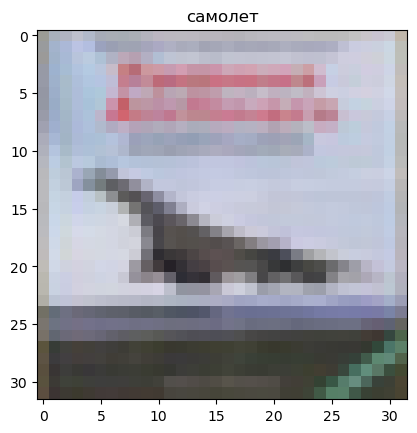

In [5]:
N = 3

plt.imshow(X_test[N])
plt.title(classes[np.argmax(y_test[N,:])])
plt.show()

In [6]:
results = pd.DataFrame() # сводная таблица результатов
step = [] # шаг
desc = [] # описание
train_acc = [] # результат на трейне
test_acc = [] # результат на тесте

1. обучить рукописную сверточную нейронную сеть (с падением размера ядра свертки и последовательностью блоков свертка-пулинг (conv-pool)-(conv-pool)-...) на датасете cifar-10

In [7]:
# Входные данные модели 
model_input = Input(shape=X_train.shape[1:])

# БЛОК 1: Свертка и max-pooling
x = Conv2D(32, (3, 3), activation='relu', padding='same')(model_input)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.5)(x)

# БЛОК 2: Свертка и max-pooling
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

# БЛОК 3: Полносвязанный слой 
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(10, activation='softmax')(x)

# Создание модели 
model_1 = Model(model_input, x, name='cnn_1')

# Компиляция модели
model_1.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])


model_1.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "cnn_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________

In [8]:
history_1 = model_1.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(X_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 429s 9ms/sample - loss: 2.1777 - acc: 0.1926 - val_loss: 1.9854 - val_acc: 0.2950
Epoch 2/10
50000/50000 [==============================] - 163s 3ms/sample - loss: 1.9183 - acc: 0.3116 - val_loss: 1.8094 - val_acc: 0.3653
Epoch 3/10
50000/50000 [==============================] - 177s 4ms/sample - loss: 1.7427 - acc: 0.3736 - val_loss: 1.6545 - val_acc: 0.4063
Epoch 4/10
50000/50000 [==============================] - 177s 4ms/sample - loss: 1.6205 - acc: 0.4149 - val_loss: 1.5473 - val_acc: 0.4396
Epoch 5/10
50000/50000 [==============================] - 174s 3ms/sample - loss: 1.5330 - acc: 0.4480 - val_loss: 1.4761 - val_acc: 0.4677
Epoch 6/10
50000/50000 [==============================] - 177s 4ms/sample - loss: 1.4547 - acc: 0.4753 - val_loss: 1.6047 - val_acc: 0.4435
Epoch 7/10
50000/50000 [==============================] - 170s 3ms/sample - loss: 1.3932 - acc: 0.4994 - val_l

**Оценка результатов** 

In [9]:
train_loss, train_m = model_1.evaluate(X_train, y_train, verbose=2)
test_loss, test_m = model_1.evaluate(X_test, y_test, verbose=2)
print(f'train_loss: {train_loss}, train_accuracy: {train_m}')
print(f'test_loss: {test_loss}, test_accuracy: {test_m}')

step.append(1)
desc.append('Базовая модель')
train_acc.append(round(train_m,2))
test_acc.append(round(test_m,2))

50000/50000 - 41s - loss: 1.1665 - acc: 0.5842
10000/10000 - 8s - loss: 1.1958 - acc: 0.5754
train_loss: 1.1665119650268554, train_accuracy: 0.5842199921607971
test_loss: 1.1957820256233216, test_accuracy: 0.5753999948501587


10000/10000 [==============================] - 9s 871us/sample - loss: 1.1958 - acc: 0.5754
Test loss: 1.1957820256233216
Test accuracy: 0.5754


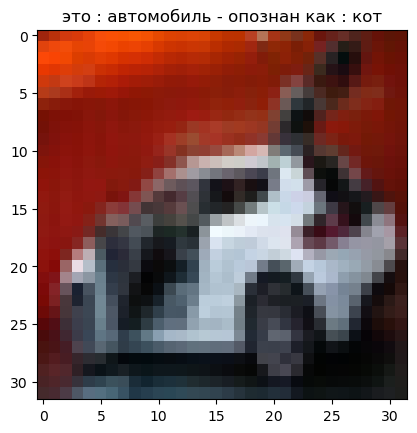

In [10]:
N = 6
scores = model_1.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

y_p = model_1.predict(X_test[N:N+1])
y_t = np.argmax(y_test[N:N+1], axis = 1 )
y_i = np.argmax(y_p, axis = 1 )
plt.imshow(X_test[N])
plt.title(f'это : {classes[y_t[0]]} - опознан как : {classes[y_i[0]]}')
plt.show()

**Оценить рост точности при увеличении ширины сети (больше фильтров)**

In [11]:
# Входные данные модели 
model_input = Input(shape=X_train.shape[1:])

# БЛОК 1: Свертка и max-pooling
x = Conv2D(32, (3, 3), activation='relu', padding='same')(model_input)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.5)(x)

# БЛОК 2: Свертка и max-pooling
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu')(x)
x = Conv2D(512, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.5)(x)

# БЛОК 3: Полносвязанный слой 
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(10, activation='softmax')(x)

# Создание модели 
model_2 = Model(model_input, x, name='cnn_2')

# Компиляция модели
model_2.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])


model_2.summary()

Model: "cnn_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 15, 128)       73856     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 256)       295168

In [12]:
history_2 = model_2.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(X_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 1182s 24ms/sample - loss: 2.1769 - acc: 0.1784 - val_loss: 1.9819 - val_acc: 0.2649
Epoch 2/10
50000/50000 [==============================] - 1154s 23ms/sample - loss: 1.9739 - acc: 0.2758 - val_loss: 1.8129 - val_acc: 0.3630
Epoch 3/10
50000/50000 [==============================] - 1153s 23ms/sample - loss: 1.8043 - acc: 0.3462 - val_loss: 1.9454 - val_acc: 0.2782
Epoch 4/10
50000/50000 [==============================] - 1159s 23ms/sample - loss: 1.6834 - acc: 0.3845 - val_loss: 1.7351 - val_acc: 0.3903
Epoch 5/10
50000/50000 [==============================] - 1152s 23ms/sample - loss: 1.5928 - acc: 0.4182 - val_loss: 1.5517 - val_acc: 0.4402
Epoch 6/10
50000/50000 [==============================] - 1157s 23ms/sample - loss: 1.5103 - acc: 0.4514 - val_loss: 1.4195 - val_acc: 0.4935
Epoch 7/10
50000/50000 [==============================] - 1163s 23ms/sample - loss: 1.4424 - acc: 

**Оценка результатов**

In [13]:
train_loss, train_m = model_2.evaluate(X_train, y_train, verbose=2)
test_loss, test_m = model_2.evaluate(X_test, y_test, verbose=2)
print(f'train_loss: {train_loss}, train_accuracy: {train_m}')
print(f'test_loss: {test_loss}, test_accuracy: {test_m}')

step.append(2)
desc.append('Шире - больше каналов')
train_acc.append(round(train_m,2))
test_acc.append(round(test_m,2))

50000/50000 - 260s - loss: 1.2660 - acc: 0.5533
10000/10000 - 52s - loss: 1.2891 - acc: 0.5429
train_loss: 1.2659806127548219, train_accuracy: 0.5533400177955627
test_loss: 1.289065739440918, test_accuracy: 0.542900025844574


10000/10000 [==============================] - 53s 5ms/sample - loss: 1.2891 - acc: 0.5429
Test loss: 1.289065739440918
Test accuracy: 0.5429


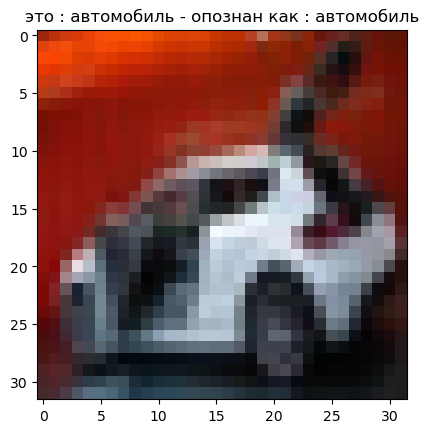

In [14]:
N = 6
scores = model_2.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

y_p = model_2.predict(X_test[N:N+1])
y_t = np.argmax(y_test[N:N+1], axis = 1 )
y_i = np.argmax(y_p, axis = 1 )
plt.imshow(X_test[N])
plt.title(f'это : {classes[y_t[0]]} - опознан как : {classes[y_i[0]]}')
plt.show()

**Оценить рост точности при увеличении глубины сети (больше слоев)**

In [15]:
# Входные данные модели 
model_input = Input(shape=X_train.shape[1:])

# БЛОК 1: Свертка и max-pooling
x = Conv2D(32, (3, 3), activation='relu', padding='same')(model_input)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.5)(x)

# БЛОК 2: Свертка и max-pooling
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.5)(x)

# БЛОК 3: Свертка и max-pooling
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.5)(x)

# БЛОК 4: Свертка и max-pooling
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.5)(x)

# БЛОК 5: Полносвязанный слой 
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(10, activation='softmax')(x)

# Создание модели 
model_3 = Model(model_input, x, name='cnn_3')

# Компиляция модели
model_3.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])


model_3.summary()

Model: "cnn_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 13, 13, 64)        36928 

In [16]:
history_3 = model_3.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(X_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 193s 4ms/sample - loss: 2.2932 - acc: 0.1123 - val_loss: 2.2827 - val_acc: 0.1580
Epoch 2/10
50000/50000 [==============================] - 192s 4ms/sample - loss: 2.1863 - acc: 0.1755 - val_loss: 2.2085 - val_acc: 0.1674
Epoch 3/10
50000/50000 [==============================] - 193s 4ms/sample - loss: 2.1222 - acc: 0.1927 - val_loss: 2.2565 - val_acc: 0.1285
Epoch 4/10
50000/50000 [==============================] - 195s 4ms/sample - loss: 2.0621 - acc: 0.1916 - val_loss: 1.9885 - val_acc: 0.2077
Epoch 5/10
50000/50000 [==============================] - 192s 4ms/sample - loss: 1.9986 - acc: 0.1926 - val_loss: 2.3704 - val_acc: 0.1203
Epoch 6/10
50000/50000 [==============================] - 191s 4ms/sample - loss: 1.9661 - acc: 0.2014 - val_loss: 1.9106 - val_acc: 0.2266
Epoch 7/10
50000/50000 [==============================] - 192s 4ms/sample - loss: 1.9333 - acc: 0.2118 - val_l

**Оценка результатов**

In [17]:
train_loss, train_m = model_3.evaluate(X_train, y_train, verbose=2)
test_loss, test_m = model_3.evaluate(X_test, y_test, verbose=2)
print(f'train_loss: {train_loss}, train_accuracy: {train_m}')
print(f'test_loss: {test_loss}, test_accuracy: {test_m}')

step.append(3)
desc.append('Глубже - больше слоев')
train_acc.append(round(train_m,2))
test_acc.append(round(test_m,2))

50000/50000 - 46s - loss: 2.3018 - acc: 0.1616
10000/10000 - 9s - loss: 2.2983 - acc: 0.1624
train_loss: 2.301774150390625, train_accuracy: 0.16157999634742737
test_loss: 2.2983164726257326, test_accuracy: 0.1624000072479248


10000/10000 [==============================] - 10s 953us/sample - loss: 2.2983 - acc: 0.1624 - loss: 2.2940
Test loss: 2.2983164726257326
Test accuracy: 0.1624


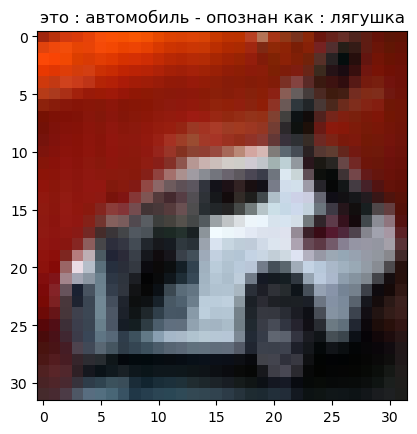

In [18]:
N = 6
scores = model_3.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

y_p = model_3.predict(X_test[N:N+1])
y_t = np.argmax(y_test[N:N+1], axis = 1 )
y_i = np.argmax(y_p, axis = 1 )
plt.imshow(X_test[N])
plt.title(f'это : {classes[y_t[0]]} - опознан как : {classes[y_i[0]]}')
plt.show()

**Сравнить с точностью полносвязной сети для этой выборки**

In [19]:
# Входные данные модели 
model_input = Input(shape=X_train.shape[1:])

# БЛОК 1: Полносвязанный слой 
x = Flatten()(model_input)
x = Dense(128, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(10, activation='softmax')(x)

# Создание модели 
model_4 = Model(model_input, x, name='cnn_4')

# Компиляция модели
model_4.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])


model_4.summary()

Model: "cnn_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               393344    
_________________________________________________________________
dense_7 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                1290  

In [20]:
history_4 = model_4.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(X_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 18s 367us/sample - loss: 2.0900 - acc: 0.2260 - val_loss: 1.9475 - val_acc: 0.3013
Epoch 2/10
50000/50000 [==============================] - 19s 376us/sample - loss: 1.9198 - acc: 0.3050 - val_loss: 1.8317 - val_acc: 0.3473
Epoch 3/10
50000/50000 [==============================] - 19s 388us/sample - loss: 1.8394 - acc: 0.3403 - val_loss: 1.7483 - val_acc: 0.3847
Epoch 4/10
50000/50000 [==============================] - 19s 381us/sample - loss: 1.7882 - acc: 0.3619 - val_loss: 1.8169 - val_acc: 0.3576
Epoch 5/10
50000/50000 [==============================] - 16s 323us/sample - loss: 1.7399 - acc: 0.3810 - val_loss: 1.7044 - val_acc: 0.3939
Epoch 6/10
50000/50000 [==============================] - 19s 381us/sample - loss: 1.7141 - acc: 0.3903 - val_loss: 1.6559 - val_acc: 0.4087
Epoch 7/10
50000/50000 [==============================] - 15s 307us/sample - loss: 1.6805 - acc: 0.4082 

**Оценка результатов**

In [21]:
train_loss, train_m = model_4.evaluate(X_train, y_train, verbose=2)
test_loss, test_m = model_4.evaluate(X_test, y_test, verbose=2)
print(f'train_loss: {train_loss}, train_accuracy: {train_m}')
print(f'test_loss: {test_loss}, test_accuracy: {test_m}')

step.append(4)
desc.append('Полносвязная сеть')
train_acc.append(round(train_m,2))
test_acc.append(round(test_m,2))

50000/50000 - 9s - loss: 1.5382 - acc: 0.4558
10000/10000 - 2s - loss: 1.5593 - acc: 0.4457
train_loss: 1.5382417695999147, train_accuracy: 0.4557799994945526
test_loss: 1.559345761871338, test_accuracy: 0.4456999897956848


10000/10000 [==============================] - 2s 196us/sample - loss: 1.5593 - acc: 0.4457
Test loss: 1.559345761871338
Test accuracy: 0.4457


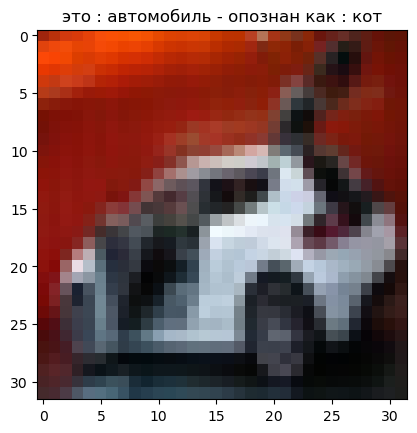

In [22]:
N = 6
scores = model_4.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

y_p = model_4.predict(X_test[N:N+1])
y_t = np.argmax(y_test[N:N+1], axis = 1 )
y_i = np.argmax(y_p, axis = 1 )
plt.imshow(X_test[N])
plt.title(f'это : {classes[y_t[0]]} - опознан как : {classes[y_i[0]]}')
plt.show()

In [23]:
results['step'] = step
results['desc'] = desc
results['train_acc'] = train_acc
results['test_acc'] = test_acc

In [24]:
results

,step,desc,train_acc,test_acc
0,1,Базовая модель,0.58,0.58
1,2,Шире - больше каналов,0.55,0.54
2,3,Глубже - больше слоев,0.16,0.16
3,4,Полносвязная сеть,0.46,0.45


### Выводы
* При увеличении количества каналов происходит в данном случае уменьшение значение метрики модели;
* увеличение глубины сети тоже увеличило метрику качества, но это всё равно ниже, чем с большом кол-вом каналов;
* полносвязная сеть без сверточных слоев показывает качество ниже, чем базовая модель со сверточными слоями.